<a href="https://colab.research.google.com/github/jx-dohwan/Natural-Language-Processing-using-Transformers/blob/main/CH6_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 532 (delta 161), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (532/532), 45.97 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (260/260), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.25.1
Using datasets v2.8.0
Using accelerate v0.15.0
Using sentencepiece v0.1.97
Using sacrebleu v2.3.1
Using rouge_score
Using nltk v3.7
Using py7zr v0.20.2


# 요약
- 요약에는 인코더-디코더 트랜스포머가 잘 맞다.

## 1. CNN/DailyMail 데이터셋
- 300,000개의 뉴스 기사와 요약의 쌍으로 구성됐다.
- 요약은 CNN과 DailyMail이 기사에 첨부한 글머리 목록의 내용인데, 요약이 본문에서 추출되지 않고 추상적이라는 중요한 특징이 있다.
- 즉, 단순한 발췌가 아니라 새로운 문장으로 구성됐다는 말이다.

In [2]:
from transformers import pipeline, set_seed

In [3]:
from datasets import load_dataset

dataset = load_dataset('cnn_dailymail', version='3.0.0')
print(f"특정 : {dataset['train'].column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

특정 : ['article', 'highlights', 'id']


- 이 데이터셋은 세가지 특징이 있다.
  - 뉴스 기사를 담은 article
  - 요약에 해당하는 highlights
  - 기사의 고유 아이디 id이다.

In [4]:
sample = dataset['train'][1]
print(f"""기사 (500 개 문장 발췌, 총 길이: {len(sample['article'])}):""")
print(sample['article'][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500 개 문장 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


- 긴 기사는 트랜스포머 모델에 문제를 일으킨다.
- 이를 처리하는 표준적이면서 가장 단순한 방법은 모델의 문맥 크기에 맞춰 텍스트를 자르는 것이다. 
- 텍스트 끝부분에 중요한 정보가 있다면 사라지겠지만 이는 모델 구조의 제약으로 생기는 불가피한 선택이다.

## 2. 텍스트 요약 파이프라인

In [5]:
sample_text = dataset['train'][1]['article'][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장한다.
summaries = {}

- 요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눈다.
- 마침표마다 그 뒤에 줄바꿈 토큰을 추가해도 되지만 그러면 U.S나 U.N같은 문자열을 처리하지 못한다.
- NLTK 패키지에는 문장의 종결과 약어에 등장하는 구두점을 구별하는 더 정교한 알고리즘이 있다.

In [6]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

string = "The U.S are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The U.S are a country.', 'The U.N. is an organization.']

### 1) 요약 기준 모델
- 기사를 요약하는 일반적인 기준 모델은 단순히 기사에서 맨 처음 문장 세 개를 선택하는 것이었다.
- 이런 기준 모델은 NLTK 문장 토크나이저로 쉽게 구현할 수 있다.

In [7]:
def three_sentence_summary(text):
  return '\n'.join(sent_tokenize(text)[:3])

summaries['baseline'] = three_sentence_summary(sample_text)

### 2) GPT-2
- 이 모델은 입력 텍스트 뒤에 'TL:DR'을 추가해 요약을 생성하는 놀라운 기능을 발휘한다.
- 너무 길어 읽지 않았다는 문구의 약어 TL:DR은 레딧 같은 사이트에서 긴 포스트를 짧게 요약할 때 종종 사용된다.
- 트랜스포머스의 pipeline()함수로 원본 논문의 방식을 재현하며 요약 작업을 실험해보겠다.
- 텍스트 생성 파이프라인을 만들고 대용량 GPT-2 모델을 로드한다.

In [8]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline('text-generation', model='gpt2-xl')
gpt2_query = sample_text + '\nTL;DR:\n'
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries['gpt2'] = "\n".join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query) : ]))

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### 3) T-5
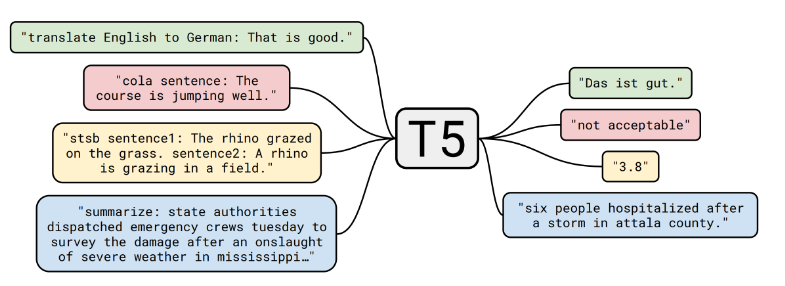

In [8]:
pipe = pipeline('summarization', model='t5-large')
pipe_out = pipe(sample_text)
summaries['t5'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

### 4) BART

In [9]:
pipe = pipeline('summarization', model='facebook/bart-large-cnn')
pipe_out = pipe(sample_text)
summaries['bart'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### 5) PEGASUS
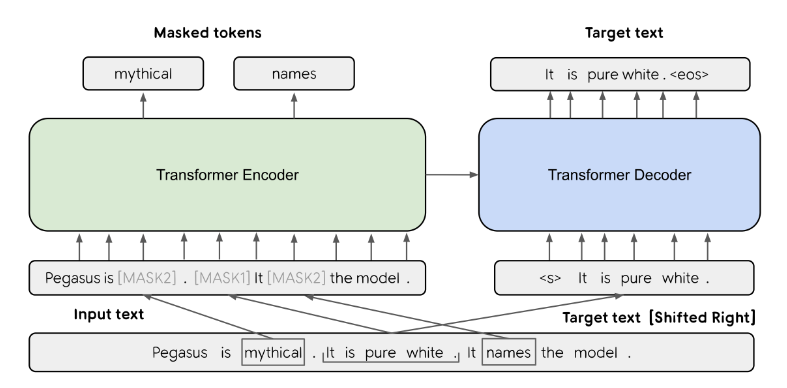

In [10]:
pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')
pipe_out = pipe(sample_text)
summaries['pegasus'] = pipe_out[0]['summary_text'].replace(" .<n>",".\n")

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

## 3. 요약 결과 비교하기

In [12]:
print('GROUND TRUTH')
print(dataset['train'][1]['highlights'])
print("")

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."

GPT2
- Miami-Dade jails have more mentally ill inmates than other counties - About
one-third of the mentally ill in Miami-Dade county are housed here - All the
mentally ill prisoners have no shoes, no beds, and no mattresse

## 4. 생성된 텍스트 품질 평가하기
- 평가 지표는 모델을 훈련할 때만이 아니라 나중에 제품 환경에서도 모델 성능을 평가하기 때문에 중요하다.
- 평가 지표가 나쁘다면 모델의 성능 저하를 눈치 채지 못하고, 평가 지표가 비즈니스 목표에 맞지 않다면 어떤 가치도 창출하지 못한다.
- 텍스트 생성 작업의 성능 특정은 감성 분석이나 개체명 인식 같은 표준적인 분류 작업만큼 쉽지 않다.
- 대표적으로는 BELR와 ROUGE가 있다.

### 1) BLEU
- 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신, 단어 또는 n-gram을 체크한다.
- BELU는 정밀도를 근간으로 하는 지표이다.
- 두 텍스트를 비교할 때 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자중 등장하는지 카운트한다.
- 그 후 생성된 텍스트 길이로 나눈다.


- 하지만 이런 단순한 정밀도에는 문제가 있다. 생성된 텍스트에 동일 단어가 반복되고 이 단어가 참조 텍스트에 등장한다고 해보자 참조 텍스트 길이만큼 반복된다면 정밀도는 완벽하다
- 이런 이유로 BELU 논문 저자들은 약간의 변화를 주었다. 단어를 참조 텍스트에 등장한 횟수만큼 카운트한다.
- 특정 b에 대해 가능한 모든 n-gram을 추출해 정밀도를 계산한다.
- 생성된 문장에서 n-gram의 등장 횟수를 카운트하는 것이 참조 문장에 나타난 횟수로 제한된다는 의미이다.
- 여러 문장에 걸쳐 생성된 텍스트가 있다면 이를 하나의 문장으로 다룬다
- 일반적으로 테스트 세트는 평가할 샘플이 하나 이상 있으니 말뭉치 c에 있는 모든 샘플을 더하도록 식을 확장한다.
- 재현율을 고러햐지 않기 때문에 짧지만 정밀하게 생성된 시퀀스가 긴 문장보다 유리하다.
- 따라서 짧게 생성된 텍스트의 정밀도 점수가 더 좋다.
- 이를 보상하기 위해 BLEU 논문의 저자들은 브레비티 패널티라는 추가항을 도입했다.
- 최솟값을 선택하므로 이 패널티는 절대 1을 넘지 않고, 생성된 텍스트의 길이가 참되 텍스트보다 더 ㅈ가을 때 지수항이 기하급수적으로 작아진다.
- 이 시점에서 왜 재현율도 고려하는 f1-score 같은 기준을 사용하지 않는지 궁금할 것이다.
- 그 이유는 번역 데이터셋에는 하나가 아니라 여러개의 참조 문장이 있는 경우가 있기 때문에 재현율을 측정하면 전체 참조 문장에 있는단어를 모두 사용하는 번역에 인센티브가 주어진다. 따라서 번역 정밀도가 높고 번역과 참조 문장의 길이가 비슷한지 확이하는 것이 좋다.

> BLEU의 또 다른 약점은 토큰화된 텍스트를 기대한다는 점이다. 만약 텍스트 토큰화를 정확히 같은 방법으로 하지 않으면 결과는 달라진다. SacreBLEU는 토큰화 단계를 내재화해 이 문제를 해결한다.

In [13]:
from datasets import load_metric

bleu_metric = load_metric('sacrebleu')

<ipython-input-13-07e747a21c2e>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('sacrebleu')


- bleu_metric 객체는 Metric 클래스의 인스턴스로 하나의 수집기처럼 작동한다.
- add() 메서드에 샘플 하나를 추가하거나 add_batch() 메서드로 배치 전체를 추가한다.
- 평가하려는 샘플을 모두 추가한 다음 compute() 메서드를 호출하면 지표가 계산된다.
- 이 메서드는 몇 개의 값으로 구성된 딕셔너리를 반환한다.
- 각 n-gram에 대한 정밀도, 길이 패널티, 최종 BLEU 점수등이다.

In [15]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [16]:

bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### 2) ROUGE
- ROUGE 점수는 높은 재현율이 정밀도보다 훨씬 더 중요한 요약 같은 애플리케이션을 위해 특별히 개발되었다.
- 이 점수는 생성된 텍스트와 참조 텍스트에서 여러가지 N-GRAM이 얼마나 자주 등장하는지 비교한다는 점에서 bleu와 매우 비슷하다. 
- 하지만 ROUGE는 참조 텍스트에 있는 N-GRAM이 생성된 텍스트에 얼마나 많이 등장하는지도 확인한다는 점이 다르다.
- 따라서 ROUGE는 분모에서 참조 텍스트의 N-GRAM이 생성된 텍스트에 얼마나 많이 등장하는지 카운트하도록 정밀도 공식을 조금 수정해 사용한다.
- 이것이 ROUGE의 원래 공식이다. 나중에 연구자들은 정밀도를 완전히 제거하면 부정적인 영향이 커짐을 알았다.
- 클리핑 카운트를 하지 않는 BLEU 공식으로 돌아가 정밀도를 측정한 다음 정밀도와 재현율 ROUGE 점수를 조화 평균하면 F1-SCORE가 나온다.
- 이 점수가 오늘날 일반적으로 사용되는 ROUGE 점수이다.
- ROUGE에는 가장 긴 공퉁 부분 시퀀스를 측정하는 별도의 점수 ROUGE-L이 있다.
- LCS는 어떤 문자열 쌍에도 계산이 가능하다. 
- 예를들어 ABAB와 ABC의 LCS는 AB이고 길이는 2이다
- 두 샘플 사이에서 이 값을 비교하려면 긴 텍스트가 유리하므로 어떤 식으로든 정규화가 필요하다.
- 이를 위해 ROUGE 개발자는 F-SCORE와 같은 방식을 고안했다.
- 이 방식에서는 참조 텍스트와 생성 텍스트의 길이로 LCS를 정규화한 다음 정규화된 두 점수를 혼합했다.
- LCS 점수는 이런 식으로 적절히 정규화되어 샘플끼리 비교가 가능해진다.
- 데이터셋 구현은 두 종류의 ROUGE 점수를 계산한다.
- 하나는 문장마다 점수를 계산해서 요약에 대해 평균한 점수 ROUGE-L이고 
- 다른 하나는 전체 요약에 대해 계산한 점수 ROUGE-Lsum이다.


In [17]:
rouge_metric = load_metric('rouge')

In [19]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.275229,0.093458,0.201835,0.275229
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232
